In [1]:
import pandas as pd

df = pd.read_csv("data/SDSS_galaxies.csv")
df

,u,g,r,i,z,specClass,redshift,redshift_err
0,18.31537,17.03378,16.43044,16.07336,15.79528,GALAXY,0.057006,0.000007
1,19.56470,17.89683,16.79172,16.30632,15.94328,GALAXY,0.152668,0.000030
2,19.25199,19.00241,18.72587,18.55749,18.58451,QSO,1.448379,0.000437
3,19.30206,17.12601,16.01106,15.51805,15.05948,GALAXY,0.105601,0.000025
4,18.39921,17.21244,16.64964,16.36866,16.19744,GALAXY,0.032242,0.000042
...,...,...,...,...,...,...,...,...
49995,19.32040,18.14041,17.67549,17.40596,17.21421,GALAXY,0.053542,0.000010
49996,19.15220,19.03598,19.01944,18.82136,18.77312,QSO,1.835785,0.000343
49997,16.70967,15.62431,15.14085,14.89638,14.70517,GALAXY,0.025292,0.000011
49998,18.72269,17.00193,16.28900,15.88266,15.57863,QSO,0.043968,0.000020


In [2]:
features = df.drop(("specClass"), axis=1)
labels = df["specClass"]
labels.value_counts()

specClass
GALAXY    42822
QSO        7178
Name: count, dtype: int64

In [3]:
pd.options.mode.use_inf_as_na = True
features.isna().any()

/tmp/ipykernel_139847/1724771793.py:1: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  pd.options.mode.use_inf_as_na = True


u               False
g               False
r               False
i               False
z               False
redshift        False
redshift_err    False
dtype: bool

In [4]:
(features <= 0.0).any()

u               False
g               False
r               False
i               False
z               False
redshift         True
redshift_err     True
dtype: bool

In [5]:
#i wanted to rescale the brightness to account for differences in redshift, but some of the redshifts are negative. this makes sence physically, but means my adjustment for distance gives inf, so i'm just going to ignore that. In fact, i'm going to ignore the redshift altogether as you said to use colour data and redshift isn't colour. In the real world, i would pass it into the network as an extra parameter though.
features = features.drop(["redshift", "redshift_err"], axis=1)
features

,u,g,r,i,z
0,18.31537,17.03378,16.43044,16.07336,15.79528
1,19.56470,17.89683,16.79172,16.30632,15.94328
2,19.25199,19.00241,18.72587,18.55749,18.58451
3,19.30206,17.12601,16.01106,15.51805,15.05948
4,18.39921,17.21244,16.64964,16.36866,16.19744
...,...,...,...,...,...
49995,19.32040,18.14041,17.67549,17.40596,17.21421
49996,19.15220,19.03598,19.01944,18.82136,18.77312
49997,16.70967,15.62431,15.14085,14.89638,14.70517
49998,18.72269,17.00193,16.28900,15.88266,15.57863


In [6]:
# now i'm going to apply a standard scalar so the means and standard deviations are all the same. this way it's easier for the network to equally weight all parameters.
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(features)
features = scaler.transform(features)

features

array([[-0.69046105, -0.49446602, -0.38907122, -0.3732382 , -0.38520348],
       [ 1.08600143,  0.44067523, -0.06168027, -0.17732689, -0.26906981],
       [ 0.64134903,  1.63860521,  1.69104114,  1.71582935,  1.80346905],
       ...,
       [-2.97365748, -2.02167018, -1.55769413, -1.36303774, -1.24059863],
       [-0.11127965, -0.52897648, -0.51724376, -0.53361032, -0.55520592],
       [ 1.02726141,  0.33764229,  0.04356547, -0.03961038, -0.10166468]])

In [7]:
# now I want to change the label data so that it has two columns. left column will be 1 for quasar and vise versa. I tried a single column being either 1 or 0 earlier, and it didn't work very well. not sure if this was the reson, but i'm trying this anyways.
labels1 = labels.replace("QSO", 1)
labels1 = labels1.replace("GALAXY", 0)
labels2 = labels.replace("GALAXY", 1)
labels2 = labels2.replace("QSO", 0)
frame = {"QSO": labels1, "GALAXY": labels2}
labels = pd.DataFrame(frame)
labels

/tmp/ipykernel_139847/3915905244.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  labels1 = labels1.replace("GALAXY", 0)
/tmp/ipykernel_139847/3915905244.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  labels2 = labels2.replace("QSO", 0)


,QSO,GALAXY
0,0,1
1,0,1
2,1,0
3,0,1
4,0,1
...,...,...
49995,0,1
49996,1,0
49997,0,1
49998,1,0


In [8]:
# this is an unbalanced dataset so i am going to balance it with random undersampling. I don't want any weird artefacts from a data augmentation process so I don't want to oversample. if it turns out we don't have enough data, I'll come back and oversample it.
from imblearn.under_sampling import RandomUnderSampler
import numpy as np

labels = labels.to_numpy()
sampler = RandomUnderSampler(sampling_strategy="not minority")
features, labels = sampler.fit_resample(features, labels)

labels2 = [] # the undersampler destroyed the shape of my array. It took forever to find this bug!
for label in labels:
    if label == 1:
        labels2.append([1,0])
    else:
        labels2.append([0,1])
labels = np.asarray(labels2)

print(labels)
print(features)

[[0 1]
 [0 1]
 [0 1]
 ...
 [1 0]
 [1 0]
 [1 0]]
[[ 0.64134903  1.63860521  1.69104114  1.71582935  1.80346905]
 [ 0.52428135  1.6564618   1.6904793   1.86182095  1.9684495 ]
 [ 0.80465793  1.99598617  2.03724474  1.88486341  1.91574207]
 ...
 [ 0.06441428 -0.15129015  0.08606613  0.19121782  0.23760259]
 [ 0.72739014  0.41008716  0.08100954  0.02970199 -0.06457253]
 [ 0.42232882  0.05335631  0.02578588  0.01510283  0.04968575]]


In [11]:
# now i need to split my datasets.
from sklearn.model_selection import train_test_split
#split_location = 10000
#train_features = features[:split_location]
#train_labels = labels[:split_location][:]
#test_features = features[split_location:]
#test_labels = labels[split_location:]
train_features, test_features, train_labels, test_labels = train_test_split(features, labels)
print(train_labels)
print(train_features)

[[0 1]
 [1 0]
 [1 0]
 ...
 [1 0]
 [0 1]
 [1 0]]
[[ 0.92301956  1.94361913  2.13876602  2.02263878  1.98731337]
 [ 1.01034042  0.92459092  0.72699226  0.63966266  0.65201934]
 [ 1.0567665  -0.03187422 -0.43408204 -0.49304214 -0.58967722]
 ...
 [-1.33431192 -1.58165916 -1.51885452 -1.46392837 -1.42656945]
 [ 0.63749559  1.60194936  1.87543416  1.85487458  1.9288228 ]
 [ 0.03236393 -0.6884072  -0.95378616 -0.9531764  -0.98423354]]


f1 score: 0.9431029697474327
true positives: 1699
true negatives: 1685
false positives: 139
false negatives: 66


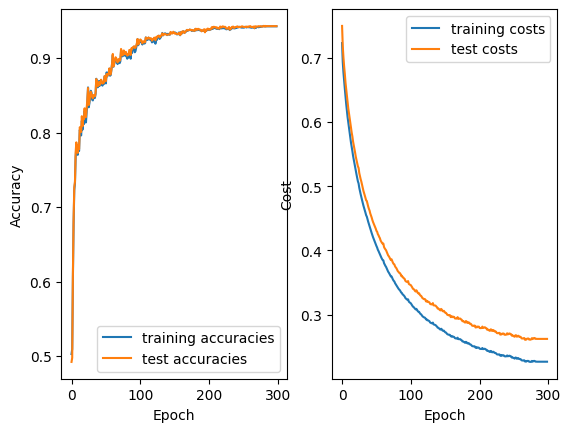

In [71]:
# this is a binary classification problem so the standard approach is to start with a sigmoidal activation function and the binary cross entopy cost function. i'm just going to initialize a network with hyperparameters that feel right and see how it does.
import neural_network as nn
from importlib import reload
reload(nn)
import matplotlib.pyplot as plt

network = nn.NeuralNetwork([5,30,30,2], cost=nn.CategoricalCrossEntropy, activation_function=nn.Sigmoid, output_function=nn.Softmax)
network.SGD(train_features, train_labels, test_features, test_labels, initial_learning_rate=0.002, regularization_parameter=1.0, stopping_threshold=32, batch_size=300)
network.plot_performance()

f1 score: 0.8324687213915166
true positives: 1364
true negatives: 1676
false positives: 148
false negatives: 401


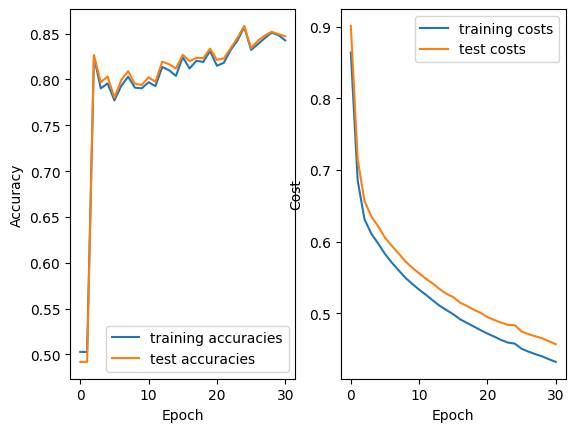

In [72]:
# that took a while. there was a bug with the shape of the data array which caused it to just not learn.
# i want to do validation curves for this, but I would have to modify my neural network somewhat heavily to use the ones from sklearn.
# so it will just try a bunch of manually set values. it seems to be pretty good  already, so that should be fine.
# I'm going to set the epochs low while I do this sot i don't waist my whole day.
# there are a bunch of plots below, you can just scroll down past them if you are uninterested.
# Ii start by changing the shape of the network
network = nn.NeuralNetwork([5,30,30,2], cost=nn.CategoricalCrossEntropy, activation_function=nn.Sigmoid, output_function=nn.Softmax)
network.SGD(train_features, train_labels, test_features, test_labels, initial_learning_rate=0.002, regularization_parameter=1.0, stopping_threshold=32, batch_size=300, epochs = 30)
network.plot_performance()


it started
f1 score: 0.9456066945606695
true positives: 1695
true negatives: 1699
false positives: 125
false negatives: 70


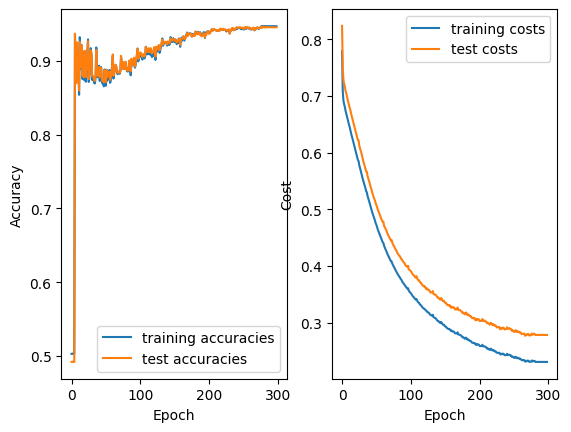

In [74]:
print("it started")
network = nn.NeuralNetwork([5,30,30,30,2], cost=nn.CategoricalCrossEntropy, activation_function=nn.Sigmoid, output_function=nn.Softmax)
network.SGD(train_features, train_labels, test_features, test_labels, initial_learning_rate=0.002, regularization_parameter=1.0, stopping_threshold=32, batch_size=300)
network.plot_performance()

it started
f1 score: 0.8841446057500711
true positives: 1553
true negatives: 1629
false positives: 195
false negatives: 212


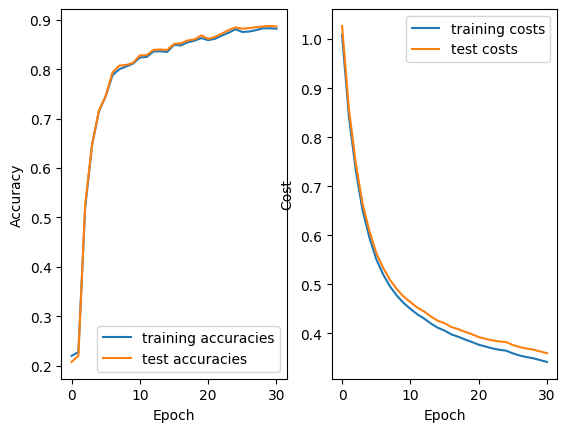

In [75]:
print("it started")
network = nn.NeuralNetwork([5,30,2], cost=nn.CategoricalCrossEntropy, activation_function=nn.Sigmoid, output_function=nn.Softmax)
network.SGD(train_features, train_labels, test_features, test_labels, initial_learning_rate=0.002, regularization_parameter=1.0, stopping_threshold=32, batch_size=300, epochs=30)
network.plot_performance()

it started
f1 score: 0.9009843659525189
true positives: 1556
true negatives: 1691
false positives: 133
false negatives: 209


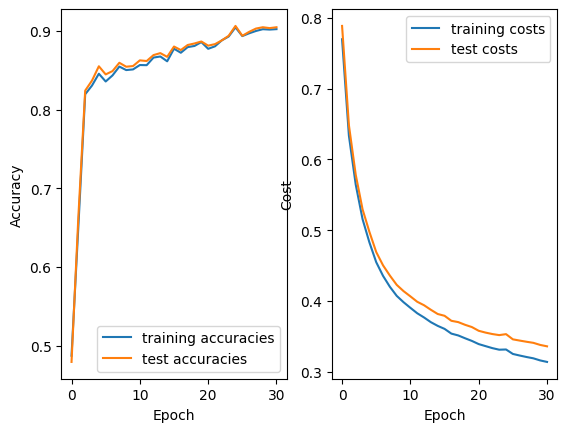

In [77]:
# it seems a single hidden layer is optimal
print("it started")
network = nn.NeuralNetwork([5,40,2], cost=nn.CategoricalCrossEntropy, activation_function=nn.Sigmoid, output_function=nn.Softmax)
network.SGD(train_features, train_labels, test_features, test_labels, initial_learning_rate=0.002, regularization_parameter=1.0, stopping_threshold=32, batch_size=300, epochs=30)
network.plot_performance()

it started
f1 score: 0.8883774453394706
true positives: 1544
true negatives: 1657
false positives: 167
false negatives: 221


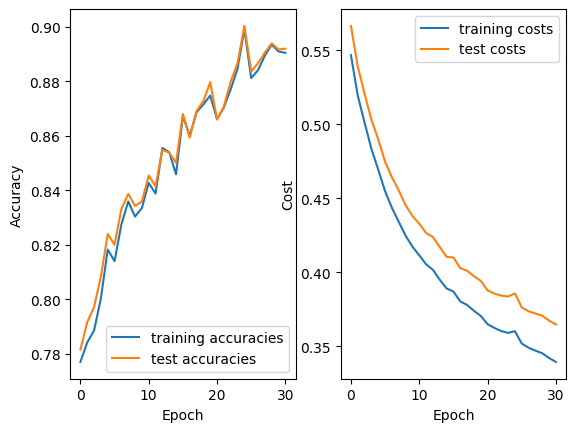

In [78]:
print("it started")
network = nn.NeuralNetwork([5,50,2], cost=nn.CategoricalCrossEntropy, activation_function=nn.Sigmoid, output_function=nn.Softmax)
network.SGD(train_features, train_labels, test_features, test_labels, initial_learning_rate=0.002, regularization_parameter=1.0, stopping_threshold=32, batch_size=300, epochs=30)
network.plot_performance()

it started
f1 score: 0.9662858735023684
true positives: 1734
true negatives: 1734
false positives: 90
false negatives: 31
final accuracy: 0.9662858735023684
final cost: 0.1788349621518141


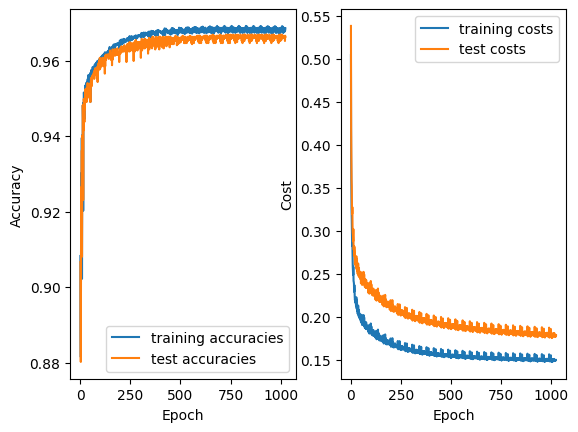

In [92]:
# 40 hidden neurons it is. I'm going to do the rest of the tests in place so it doesn't produce a massive wall of plots.
from importlib import reload
reload(nn)
print("it started")
network = nn.NeuralNetwork([5,40,2], cost=nn.CategoricalCrossEntropy, activation_function=nn.Sigmoid, output_function=nn.Softmax)
network.SGD(train_features, train_labels, test_features, test_labels, initial_learning_rate=0.02, regularization_parameter=2.0, stopping_threshold=64, batch_size=300)
network.plot_performance()

classification report
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1811
           1       0.96      0.98      0.97      1777

   micro avg       0.97      0.97      0.97      3588
   macro avg       0.97      0.97      0.97      3588
weighted avg       0.97      0.97      0.97      3588
 samples avg       0.97      0.97      0.97      3588



/home/beets/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Text(0.5, 1.0, 'raw confusion matrix')

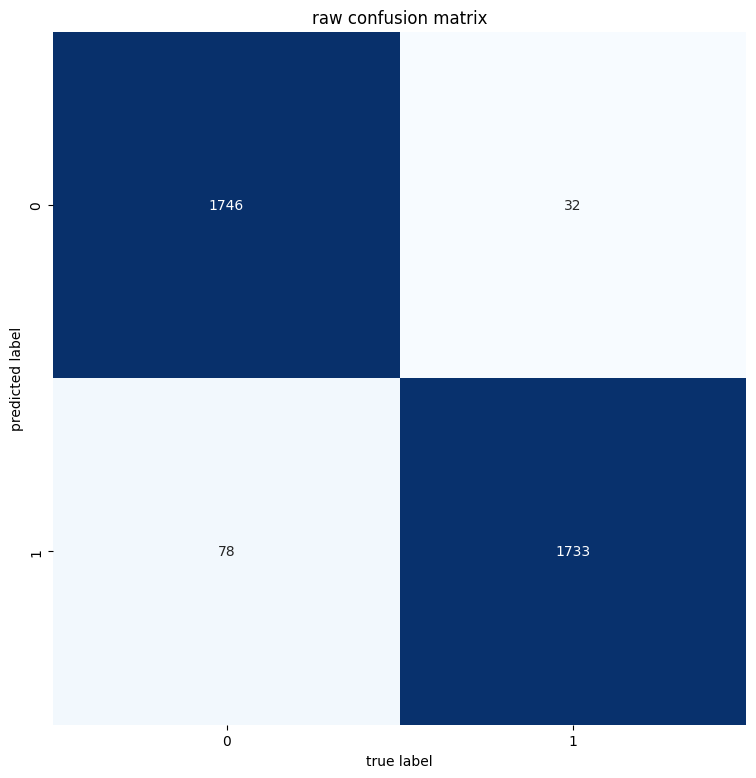

In [106]:
# brilliant! that's the final network. i think it does pretty well.
# it's not perfect. it struggles a bit more with false quasars than false galaxies.
# which is probably the opposite of how you want it. Overall though, it's as good
# as anything i hoped for. I doubt the random forest can beat it.
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sb

forest = RandomForestClassifier().fit(train_features, train_labels)
predictions = forest.predict(test_features)
print("classification report")
print(classification_report(predictions, test_labels))
# Confusion Matrices
confusion_matrix = confusion_matrix(test_labels.T[0], predictions.T[0])
fig1 = plt.figure(figsize=(9, 9))
sb.heatmap(confusion_matrix.T, square=True, annot=True, fmt='d', cbar=False, cmap='Blues')
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.title("raw confusion matrix")

In [ ]:
# unfortunately for my neural network, i haven't even optimised the random forest and it's doing better  in every metric.
# the random forest is faster (it might not be faster to run, but it's certainly faster to train), it has a higher accuracy and f1 score,
# and it was way easier to make. the neural network was fiddly and hard for me to work with, but the random forest just worked.
# this all makes sense though, considerig this was my first attempt at a neural network, and random forests exist because they are good at classification tasks like this.
# 